# Week 12: Colab Experiment

# I. Introduction
In this exercise, we learn an autoencoder to reconstruct the MNIST images and extract the representations.

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random


In [ ]:
# Run this once to load the train and test data straight into a dataloader class
# that will provide the batches
batch_size_train = 64
batch_size_test = 1000
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 85526669.14it/s]


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 61867055.07it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 20804178.34it/s]


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12072578.43it/s]


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



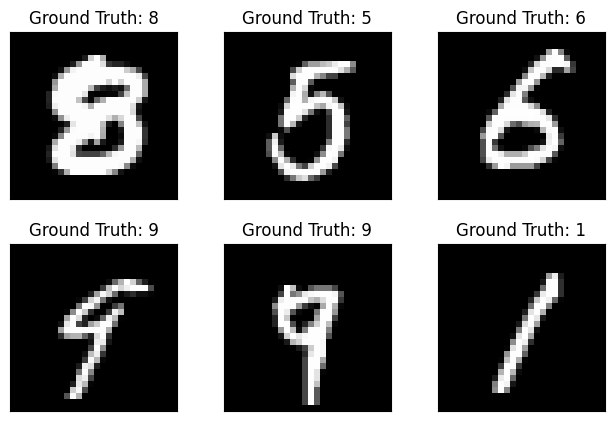

In [ ]:

# Let's draw some of the training data
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

# II. Methods
The encoder at least 3 hidden layers, each with 128, 64, and 2 hidden units respectively. The decoder also has at least 3 layers with the same number of hidden units in reversed order. We train the autoencoder with 10 epochs, learning_rate = 2e-3, to minimize the MSE.

In [ ]:
# Finish the Model
class LAutoencoder(nn.Module):
# TODO
    def __init__(self):
        super(LAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2),
            )
        self.decoder = nn.Sequential(
            # reversed order
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
            )
# TODO
    def forward(self, x):
        latent = self.encoder(x)
        x = self.decoder(latent)
        return x,latent

# Training steps

In [ ]:
num_epochs = 10
learning_rate = 2e-3


model = LAutoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(
    model.parameters(), lr=learning_rate)

# TODO : Fininsh the training steps
for epoch in range(num_epochs):
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.view(-1, 28*28)
        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.data.item()}')

epoch [1/10], loss:0.6954658627510071
epoch [2/10], loss:0.6517167091369629
epoch [3/10], loss:0.6667506694793701
epoch [4/10], loss:0.6651085019111633
epoch [5/10], loss:0.6698242425918579
epoch [6/10], loss:0.6969861388206482
epoch [7/10], loss:0.6515958905220032
epoch [8/10], loss:0.5812041163444519
epoch [9/10], loss:0.6483709216117859
epoch [10/10], loss:0.6529334187507629


## III. Results

We train the autoencoder model and apply it to the test set. There is no validation set here, we simply take the model at the end of the training procedure. The scatter plot of the embeddings are shown below, with each digit colored differently.

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


def scatter_plot(data_loader):

  d = {0: 'red', 1: "green", 2: "blue", 3: "maroon", 4: "yellow",
      5: "pink", 6: "brown", 7: "black", 8: "teal", 9: "aqua"}

  colors = []
  latent_variables = []
  labels = []

  for data in test_loader:
    img, label = data
    img = img.view(img.size(0), -1)
    model.cpu()
    _,latent = model(img)
    latent_variables.append(latent)
    labels.append(label)


  latent_variables = torch.cat(latent_variables, dim=0)
  labels = torch.cat(labels, dim=0)


  df = pd.DataFrame(data = latent_variables.detach().numpy(), columns = ['Latent feature 1', 'Latent feature 2'])
  df['label'] = labels.numpy()

  fig = plt.figure(dpi=200)
  sns.scatterplot(data=df, x="Latent feature 1", y="Latent feature 2", hue="label", palette="deep")
  plt.show()

The test set:


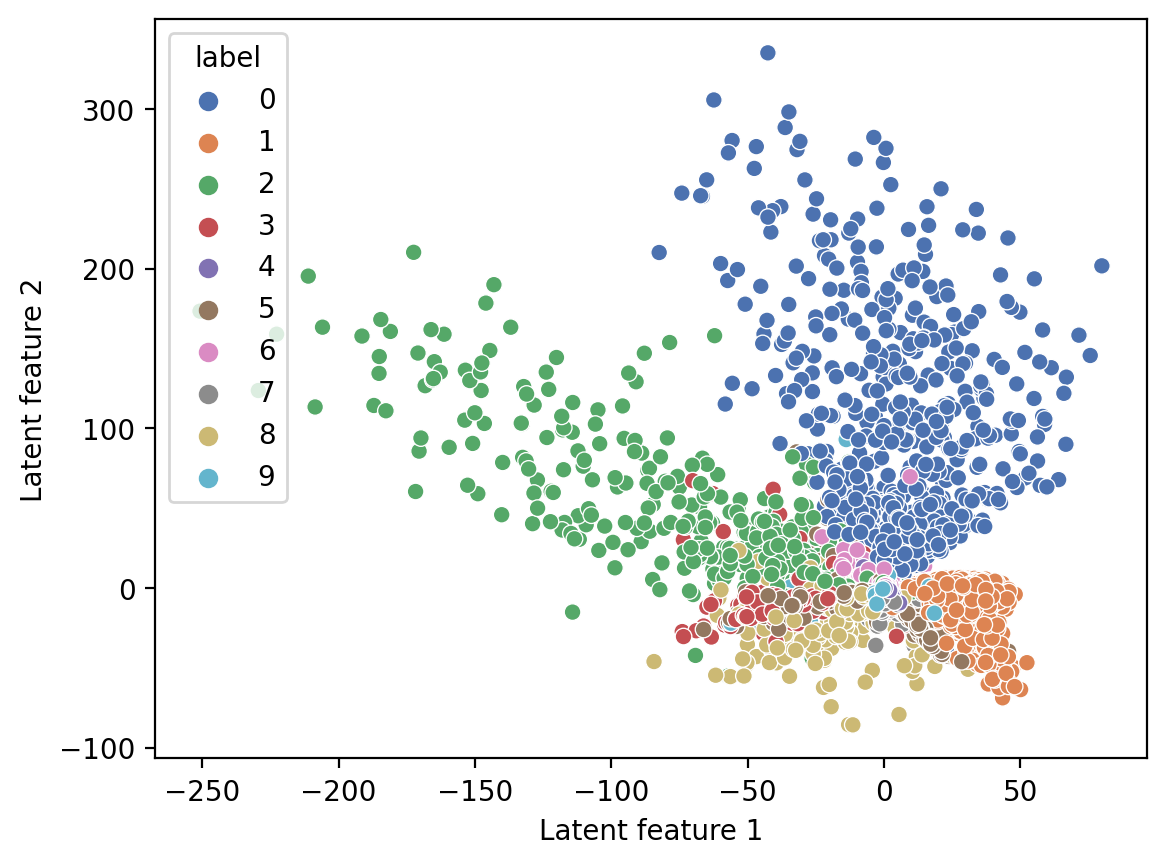

In [ ]:
print("The test set:")
scatter_plot(test_loader)

# IV. Conclusion and Discussion



In [ ]:
#Conclusion
#首先我先將tensor flatten成784的1D Array，接著利用autoencoder中的encoder先將資料逐步壓縮成2維(因為2維可以方便畫圖觀看),
#由圖片上可以看到，0~9的class各別分布在二維空間中Embedding space的特定位置，儘管效果不是那麼的好，但我們仍然可以看出一些端倪。
#接著再利用autoencoder中的decoder還原資料，將資料逐步還原成原本的維度(1*28*28)，作為模型的輸出。並且利用此輸出當作Loss的計算方式。
#Discussion
#我們的encoder與decoder分別是三層的架構，我嘗試了不同的激活函數，最後覺得ReLU的效果最佳。
#此外我也有試著增加一層，該層有256個units，我發現效果會非常差，Loss大約0.8左右。
#雖然這次實驗沒有達到助教所說的baseline, 但我在實作的過程中也查詢了蠻多關於autoencoder的知識，因此學到了蠻多。
#希望下次助教能夠公布如何達到baseline。(因為我試了蠻多方式都無法達到，因此想知道原因)